In [ ]:
''' Leading Reco Jet Dist (pT) '''
import uproot 
import awkward as ak
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
import hist

filesUFO = [f"user.tapark.41935082._00000{x}.tree.root" for x in range(1,10)] + [f"user.tapark.41935082._00001{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935082._00002{x}.tree.root" for x in range(0,8)] + ["user.tapark.41935082._000029.tree.root", "user.tapark.41935082._000030.tree.root"] 
filesPFO = [f"user.tapark.41935133._00000{x}.tree.root" for x in range(1,10)] + [f"user.tapark.41935133._00001{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935133._00002{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935133._00003{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935133._00004{x}.tree.root" for x in range(0,5)] 
filesPFO2 = [f"user.tapark.42500064._00000{x}.tree.root" for x in range(1,10)] + [f"user.tapark.42500064._00001{x}.tree.root" for x in range(0,2)]

ufoFiles = ["./ufocssk/"+x for x in filesUFO]
pfoFiles = ["./pflow/"+x for x in filesPFO]
pfo2Files = ["./PFlow_JZ2/"+x for x in filesPFO2]

h_ufo = hist.Hist(hist.axis.Regular(100, 0, 450, label="Value [GeV]"))
h_pfo = hist.Hist(hist.axis.Regular(100, 0, 450, label="Value [GeV]"))
h1_pfo_jz2 = hist.Hist(hist.axis.Regular(100, 0, 450, label="Value [GeV]"))

def fillHist(file, histogram):
    for batch in uproot.iterate(f"{file}:JetConstituentTree", ['jet_pt'], step_size=100000):
        eventData = batch["jet_pt"]/1000
        filteredData = eventData[ak.any(eventData!=0, axis=1)].tolist()
        histogram.fill([max(event) for event in filteredData])


def getHist(file_list, histogram):
    for file in file_list:
        fillHist(file, histogram)
        print(f"{file} ran")

# Set up the plot with two subplots (one for stacked histograms and one for the ratio)
fig = plt.figure(figsize=(10, 6))

# Define a gridspec with 1 row and 2 columns
gs = GridSpec(2, 1, height_ratios=[4, 1])  # First subplot will be 2x wider than the second

# Create the subplots
ax1 = fig.add_subplot(gs[0])  # Larger subplot
ax2 = fig.add_subplot(gs[1])  # Smaller subplot

s = time.time()
getHist(ufoFiles, h_ufo)
# getHist(pfoFiles, h_pfo)
getHist(pfo2Files, h1_pfo_jz2)
e = time.time()
print(f"{e-s:.2f} seconds for datasets")
# Plot stacked histograms
h_ufo.plot1d(ax=ax1, label="UFO+CSSK", color="blue", stack=True)
h1_pfo_jz2.plot1d(ax=ax1, label="PFlow_JZ2", color="red", stack=True)
ax1.set_xlabel('Value [GeV]')
ax1.set_ylabel('Number of Events')
ax1.set_yscale("log")
ax1.set_title('Distribution of Leading Reconstructed Jets (pT)')
ax1.legend()

# Calculate the ratio of the histograms (avoid division by zero)
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = h_ufo.values() / h1_pfo_jz2.values()

bin_centers = (h_ufo.axes[0].edges[:-1] + h_ufo.axes[0].edges[1:]) / 2
# # Plot the ratio
ax2.plot(bin_centers, ratio, label='Ratio (UFO+CSSK / PFlow_JZ2)', color='purple')
ax2.set_xlabel('Value [GeV]')
ax2.set_ylabel('Ratio')
ax2.set_yscale("log")
ax2.axhline(1, color='gray', linestyle='--', linewidth=1)  # Add horizontal line at ratio=1
ax2.legend()

# Show the plots
plt.tight_layout()
plt.savefig("ufocssk_pflowjz2_leadingJetPtDist.png")

In [ ]:
''' Matching Truth to Reco (eta) '''
import uproot 
import awkward as ak
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
import hist

filesUFO = [f"user.tapark.41935082._00000{x}.tree.root" for x in range(1,10)] + [f"user.tapark.41935082._00001{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935082._00002{x}.tree.root" for x in range(0,8)] + ["user.tapark.41935082._000029.tree.root", "user.tapark.41935082._000030.tree.root"] 
filesPFO = [f"user.tapark.41935133._00000{x}.tree.root" for x in range(1,10)] + [f"user.tapark.41935133._00001{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935133._00002{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935133._00003{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935133._00004{x}.tree.root" for x in range(0,5)] 
filesPFO2 = [f"user.tapark.42500064._00000{x}.tree.root" for x in range(1,10)] + [f"user.tapark.42500064._00001{x}.tree.root" for x in range(0,2)]

ufoFiles = ["./ufocssk/"+x for x in filesUFO]
pfoFiles = ["./pflow/"+x for x in filesPFO]
pfo2Files = ["./PFlow_JZ2/"+x for x in filesPFO2]

h_ufo = hist.Hist(hist.axis.Regular(100, -5, 5, label="Value [\eta]"))
h_pfo = hist.Hist(hist.axis.Regular(100, -5, 5, label="Value [\eta]"))
h_pfo_jz2 = hist.Hist(hist.axis.Regular(100, -5, 5, label="Value [\eta]"))

@nb.njit
def calcDeltaR(a,b):
    res = []
    for i in range(len(a.phi)):
        delta_r_row = []
        for j in range(len(b.phi)):
            dphi = abs(a.phi[i]-b.phi[j])
            dphi = dphi if dphi <= np.pi else 2*np.pi - dphi
            deta = a.eta[i] - b.eta[j]
            delta_r = np.sqrt(dphi**2+deta**2)
            if delta_r < 0.4:
                delta_r_row.append(1)
            else:
                delta_r_row.append(0)
        if 1 in delta_r_row:
            res.append(1)
        else:
            res.append(0)
    return res

@nb.njit
def matchingAlgorithm(dataArray1,dataArray2):
    res = [ calcDeltaR(x,y) for x,y in zip(dataArray1,dataArray2) ]
    return res

def fillHist(file, histogram):
    # for batch in uproot.iterate(f"{file}:JetConstituentTree", ['jet_pt', 'jet_eta', 'jet_phi', 'truthJet_pt', 'truthJet_eta', 'truthJet_phi'], step_size=100000):
    #     pts = batch["truthJet_pt"]
    #     cut = ak.any(pts!=0, axis=1)
    #     filteredData = batch[cut]
    #     data_t = ak.zip({"phi": filteredData["truthJet_phi"], "eta": filteredData["truthJet_eta"], "pt": filteredData["truthJet_pt"]/1000 })
    #     data_t = ak.values_astype(data_t, "float32")
    #     data_r = ak.zip({"phi": filteredData["jet_phi"], "eta": filteredData["jet_eta"], "pt": filteredData["jet_pt"]/1000 })
    #     data_r = ak.values_astype(data_r, "float32")
    #     weights = matchingAlgorithm(data_r, data_t)
    #     data = ak.zip({"pt": data_r["pt"], "eta": data_r["eta"], "weight": weights}).tolist()
    #     histogram.fill(ak.flatten(data)["eta"], weight=ak.flatten(data)["weight"])
    # --------------
    file = uproot.open(file)
    tree = file["JetConstituentTree"]
    data = tree.arrays(['truthJet_pt','truthJet_eta', 'truthJet_phi','jet_eta', 'jet_phi','jet_pt'], library="ak")
    # remove events with any empty arrays
    pts = data["jet_pt"]
    cut = ak.any(pts!=0, axis=1)
    eventData = data[cut]
    zipd_t = ak.zip({"phi": eventData["truthJet_phi"], "eta": eventData["truthJet_eta"], "pt": eventData["truthJet_pt"]/1000 })
    zipd_t = ak.values_astype(zipd_t, "float32")        
    zipd_r = ak.zip({"phi": eventData["jet_phi"], "eta": eventData["jet_eta"], "pt": eventData["jet_pt"]/1000 })
    zipd_r = ak.values_astype(zipd_r, "float32")
    weights = matchingAlgorithm(data_r, data_t)
    data = ak.zip({"pt": data_r["pt"], "eta": data_r["eta"], "weight": weights}).tolist()
    histogram.fill(ak.flatten(data)["eta"], weight=ak.flatten(data)["weight"])


def getHist(file_list, histogram):
    for file in file_list:
        s = time.time()
        fillHist(file, histogram)
        e = time.time()
        print(f"{file} | {e-s:.2f} seconds")

# Set up the plot with two subplots (one for stacked histograms and one for the ratio)
fig = plt.figure(figsize=(10, 6))

# Define a gridspec with 1 row and 2 columns
gs = GridSpec(2, 1, height_ratios=[4, 1])  # First subplot will be 2x wider than the second

# Create the subplots
ax1 = fig.add_subplot(gs[0])  # Larger subplot
ax2 = fig.add_subplot(gs[1])  # Smaller subplot

s = time.time()
getHist(ufoFiles, h_ufo)
# getHist(pfoFiles, h_pfo)
getHist(pfo2Files, h_pfo_jz2)
e = time.time()
print(f"{e-s:.2f} seconds for datasets")
# Plot stacked histograms
h_ufo.plot1d(ax=ax1, label="UFO+CSSK", color="blue", stack=True)
# h_pfo.plot1d(ax=ax1, label="PFlow", color="red", stack=True)
h_pfo_jz2.plot1d(ax=ax1, label="PFlow_JZ2", color="red", stack=True)
ax1.set_xlabel('Value [\eta]')
ax1.set_ylabel('Frequency')
ax1.set_yscale("log")
ax1.set_title('Distribution of Matched Reconstructed Jets (eta)')
ax1.legend()

# Calculate the ratio of the histograms (avoid division by zero)
with np.errstate(divide='ignore', invalid='ignore'):
    # ratio = h_ufo.values() / h_pfo.values()
    ratio = h_ufo.values() / h_pfo_jz2.values()

bin_centers = (h_ufo.axes[0].edges[:-1] + h_ufo.axes[0].edges[1:]) / 2

# # Plot the ratio
ax2.plot(bin_centers, ratio, label='Ratio (UFO+CSSK / PFlow)', color='purple')
ax2.set_xlabel('Value [\eta]')
ax2.set_ylabel('Ratio')
ax2.set_xlim(-5,5)
# ax2.set_ylim(0,2)
ax2.axhline(1, color='gray', linestyle='--', linewidth=1)  # Add horizontal line at ratio=1
ax2.legend()

# Show the plots
plt.tight_layout()
plt.savefig("ufocssk_pflowjz2_matchedRecoJetsEta.png")

./ufocssk/user.tapark.41935082._000001.tree.root | 5.01 seconds
./ufocssk/user.tapark.41935082._000002.tree.root | 1.76 seconds
./ufocssk/user.tapark.41935082._000003.tree.root | 1.66 seconds
./ufocssk/user.tapark.41935082._000004.tree.root | 1.70 seconds
./ufocssk/user.tapark.41935082._000005.tree.root | 1.79 seconds
./ufocssk/user.tapark.41935082._000006.tree.root | 1.66 seconds
./ufocssk/user.tapark.41935082._000007.tree.root | 1.75 seconds
./ufocssk/user.tapark.41935082._000008.tree.root | 1.66 seconds
./ufocssk/user.tapark.41935082._000009.tree.root | 1.73 seconds
./ufocssk/user.tapark.41935082._000010.tree.root | 2.77 seconds
./ufocssk/user.tapark.41935082._000011.tree.root | 1.16 seconds
./ufocssk/user.tapark.41935082._000012.tree.root | 56.54 seconds
./ufocssk/user.tapark.41935082._000013.tree.root | 56.07 seconds
./ufocssk/user.tapark.41935082._000014.tree.root | 58.46 seconds
./ufocssk/user.tapark.41935082._000015.tree.root | 57.18 seconds
./ufocssk/user.tapark.41935082._0000

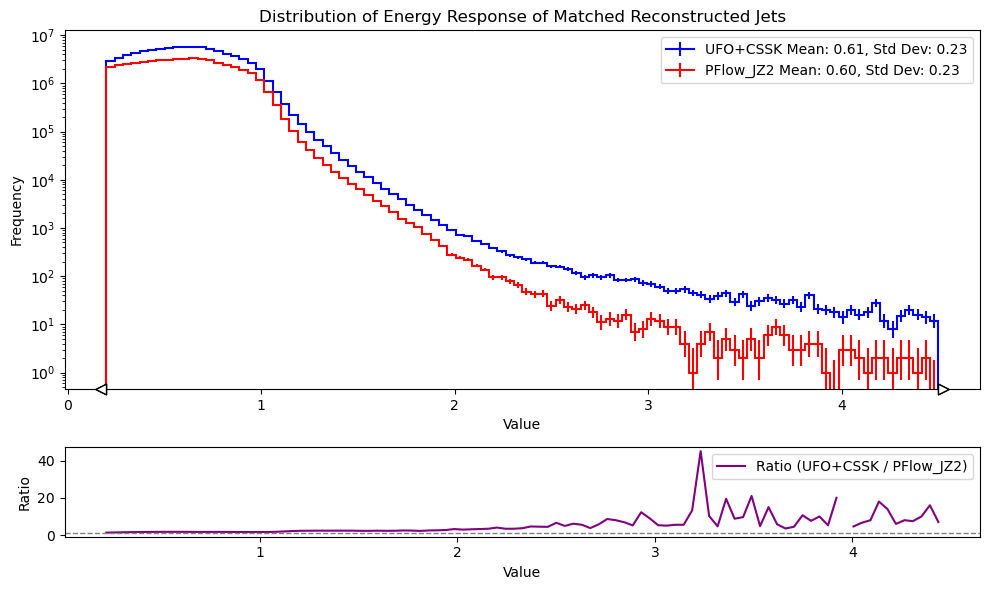

In [1]:
''' Energy Response of Matched Jets '''
import uproot 
import awkward as ak
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
import hist

filesUFO = [f"user.tapark.41935082._00000{x}.tree.root" for x in range(1,10)] + [f"user.tapark.41935082._00001{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935082._00002{x}.tree.root" for x in range(0,8)] + ["user.tapark.41935082._000029.tree.root", "user.tapark.41935082._000030.tree.root"] 
filesPFO = [f"user.tapark.41935133._00000{x}.tree.root" for x in range(1,10)] + [f"user.tapark.41935133._00001{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935133._00002{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935133._00003{x}.tree.root" for x in range(0,10)] + [f"user.tapark.41935133._00004{x}.tree.root" for x in range(0,5)] 
filesPFO2 = [f"user.tapark.42500064._00000{x}.tree.root" for x in range(1,10)] + [f"user.tapark.42500064._00001{x}.tree.root" for x in range(0,2)]

ufoFiles = ["./ufocssk/"+x for x in filesUFO]
pfoFiles = ["./pflow/"+x for x in filesPFO]
pfo2Files = ["./PFlow_JZ2/"+x for x in filesPFO2]

bin_edges = [0.2, 0.7, 1.0, 1.3, 1.8, 2.5, 2.8, 3.2, 3.5, 4.5]
bins = np.linspace(bin_edges[0], bin_edges[-1], 101)

h_ufo = hist.Hist(hist.axis.Variable(bins, label="Value [GeV]"))
h_pfo = hist.Hist(hist.axis.Variable(bins, label="Value [GeV]"))
h_pfo_jz2 = hist.Hist(hist.axis.Variable(bins, label="Value [GeV]"))

@nb.njit
def truthJetMatching(jetTArray, jetR):
    matched_t = []
    for j in range(len(jetTArray)):
        dphi = abs(jetR["phi"] - jetTArray["phi"][j])
        dphi = dphi if dphi <= np.pi else 2*np.pi - dphi # take into account periodicity
        deta = jetR["eta"] - jetTArray["eta"][j]
        delta_r = np.sqrt(dphi**2+deta**2)
        if delta_r < 0.4:
            matched_t.append(jetTArray[j])
        else:
            continue   
    return matched_t

@nb.njit
def recoJetNearby(ind, jetRArray):
    # ind is the index of the initial jet
    isNotIsolated = []
    for i in range(len(jetRArray)):
        if i==ind:
            continue
        else:
            dphi = abs(jetRArray["phi"][ind] - jetRArray["phi"][i])
            dphi = dphi if dphi <= np.pi else 2*np.pi - dphi # take into account periodicity
            deta = jetRArray["eta"][ind] - jetRArray["eta"][i]
            delta_r = np.sqrt(dphi**2+deta**2)
            if delta_r < 0.6:
                isNotIsolated.append(np.True_)
            else:
                continue
    if np.True_ in isNotIsolated:
        return np.True_
    else:
        return np.False_

@nb.njit
def calcEnergyResp(trueJetArray, recoJetArray):    
    data = []
    for i in range(len(recoJetArray)):
        matched_truth_jets = truthJetMatching(trueJetArray, recoJetArray[i])
        if len(matched_truth_jets)==0:
            continue
        else:
            max_pt_truth_jet = np.sort([jet["pt"] for jet in matched_truth_jets])[-1]
            if recoJetNearby(i, recoJetArray):
                continue
            else:
                data.append(recoJetArray["pt"][i]/max_pt_truth_jet)
    return data

@nb.njit
def getEnergyResponse(a,b):
    data = [calcEnergyResp(x,y) for x,y in zip(a,b)]
    return data

def fillHist(filename, histogram):
    for batch in uproot.iterate(f"{filename}:JetConstituentTree", ['truthJet_pt','truthJet_eta', 'truthJet_phi','jet_eta', 'jet_phi','jet_pt'], step_size=100000):
        pts = batch["truthJet_pt"]
        cut = ak.any(pts!=0, axis=1)
        eventData = batch[cut]
        zipd_t = ak.zip({"phi": eventData["truthJet_phi"], "eta": eventData["truthJet_eta"], "pt": eventData["truthJet_pt"]/1000 })
        zipd_t = ak.values_astype(zipd_t, "float32")        
        zipd_r = ak.zip({"phi": eventData["jet_phi"], "eta": eventData["jet_eta"], "pt": eventData["jet_pt"]/1000 })
        zipd_r = ak.values_astype(zipd_r, "float32")
        data_energyResp = getEnergyResponse(zipd_t,zipd_r)
        histogram.fill(ak.flatten(data_energyResp))

def getHist(file_list, histogram):
    for file in file_list:
        s = time.time()
        fillHist(file, histogram)
        e = time.time()
        print(f"{file} | {e-s:.2f} seconds")

# Set up the plot with two subplots (one for stacked histograms and one for the ratio)
fig = plt.figure(figsize=(10, 6))

# Define a gridspec with 1 row and 2 columns
gs = GridSpec(2, 1, height_ratios=[4, 1])  # First subplot will be 2x wider than the second

# Create the subplots
ax1 = fig.add_subplot(gs[0])  # Larger subplot
ax2 = fig.add_subplot(gs[1])  # Smaller subplot

s = time.time()
getHist(ufoFiles, h_ufo)
getHist(pfoFiles, h_pfo)
# getHist(pfo2Files, h_pfo_jz2)
e = time.time()
print(f"{e-s:.2f} seconds for datasets")

bin_centers_ufo = (h_ufo.axes[0].edges[:-1] + h_ufo.axes[0].edges[1:]) / 2
bin_centers_pfo = (h_pfo.axes[0].edges[:-1] + h_pfo.axes[0].edges[1:]) / 2

def getMeanStdDev(bin_centers, values):
    mean = np.sum(bin_centers * values) / np.sum(values)
    std_dev = np.sqrt(np.sum(values * (bin_centers - mean)**2) / np.sum(values))
    return mean, std_dev

mean_ufo, std_dev_ufo = getMeanStdDev(bin_centers_ufo, h_ufo.values())
mean_pfo, std_dev_pfo = getMeanStdDev(bin_centers_pfo, h_pfo.values())

label1 = f"UFO+CSSK Mean: {mean_ufo:.2f}, Std Dev: {std_dev_ufo:.2f}"
label2 = f"PFlow Mean: {mean_pfo:.2f}, Std Dev: {std_dev_pfo:.2f}"

# Plot stacked histograms
h_ufo.plot1d(ax=ax1, label=label1, color="blue", stack=True)
h_pfo.plot1d(ax=ax1, label=label2, color="red", stack=True)
# h_pfo_jz2.plot1d(ax=ax1, label=label2, color="red", stack=True)

ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_yscale("log")
ax1.set_title('Distribution of Energy Response of Matched Reconstructed Jets')
ax1.legend(loc="best")

# Calculate the ratio of the histograms (avoid division by zero)
with np.errstate(divide='ignore', invalid='ignore'):
    # ratio = h_ufo.values() / h_pfo.values()
    ratio = h_ufo.values() / h_pfo_jz2.values()

# # Plot the ratio
ax2.plot(bin_centers_ufo, ratio, label='Ratio (UFO+CSSK / PFlow)', color='purple')
ax2.set_xlabel('Value')
# ax2.set_xlabel('Value [\eta]')
ax2.set_ylabel('Ratio')
# ax2.set_yscale('log')
ax2.axhline(1, color='gray', linestyle='--', linewidth=1)  # Add horizontal line at ratio=1
ax2.legend()

# Show the plots
plt.tight_layout()
plt.savefig("test_ufocssk_pflow_energyResponsePt.png")
    

In [4]:
h_pfo = hist.Hist(hist.axis.Variable(bins, label="Value [GeV]"))

In [5]:
getHist(pfoFiles, h_pfo)

./pflow/user.tapark.41935133._000001.tree.root | 2.74 seconds
./pflow/user.tapark.41935133._000002.tree.root | 2.75 seconds
./pflow/user.tapark.41935133._000003.tree.root | 2.84 seconds
./pflow/user.tapark.41935133._000004.tree.root | 3.54 seconds
./pflow/user.tapark.41935133._000005.tree.root | 3.55 seconds
./pflow/user.tapark.41935133._000006.tree.root | 3.60 seconds
./pflow/user.tapark.41935133._000007.tree.root | 3.51 seconds
./pflow/user.tapark.41935133._000008.tree.root | 3.54 seconds
./pflow/user.tapark.41935133._000009.tree.root | 3.66 seconds
./pflow/user.tapark.41935133._000010.tree.root | 5.44 seconds
./pflow/user.tapark.41935133._000011.tree.root | 2.47 seconds
./pflow/user.tapark.41935133._000012.tree.root | 51.65 seconds
./pflow/user.tapark.41935133._000013.tree.root | 34.85 seconds
./pflow/user.tapark.41935133._000014.tree.root | 35.10 seconds
./pflow/user.tapark.41935133._000015.tree.root | 34.50 seconds
./pflow/user.tapark.41935133._000016.tree.root | 34.40 seconds
./p

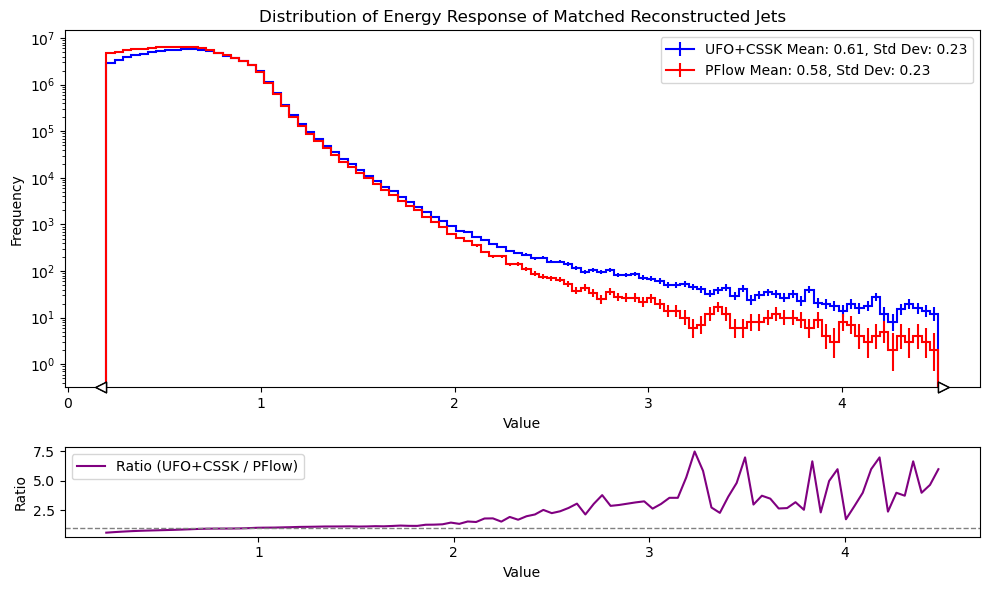

In [7]:
# Set up the plot with two subplots (one for stacked histograms and one for the ratio)
fig = plt.figure(figsize=(10, 6))

# Define a gridspec with 1 row and 2 columns
gs = GridSpec(2, 1, height_ratios=[4, 1])  # First subplot will be 2x wider than the second

# Create the subplots
ax1 = fig.add_subplot(gs[0])  # Larger subplot
ax2 = fig.add_subplot(gs[1])  # Smaller subplot

mean_ufo, std_dev_ufo = getMeanStdDev(bin_centers_ufo, h_ufo.values())
mean_pfo, std_dev_pfo = getMeanStdDev(bin_centers_pfo, h_pfo.values())

label1 = f"UFO+CSSK Mean: {mean_ufo:.2f}, Std Dev: {std_dev_ufo:.2f}"
label2 = f"PFlow Mean: {mean_pfo:.2f}, Std Dev: {std_dev_pfo:.2f}"

# Plot stacked histograms
h_ufo.plot1d(ax=ax1, label=label1, color="blue", stack=True)
h_pfo.plot1d(ax=ax1, label=label2, color="red", stack=True)
# h_pfo_jz2.plot1d(ax=ax1, label=label2, color="red", stack=True)

ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_yscale("log")
ax1.set_title('Distribution of Energy Response of Matched Reconstructed Jets')
ax1.legend(loc="best")

# Calculate the ratio of the histograms (avoid division by zero)
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = h_ufo.values() / h_pfo.values()
    # ratio = h_ufo.values() / h_pfo_jz2.values()

# # Plot the ratio
ax2.plot(bin_centers_ufo, ratio, label='Ratio (UFO+CSSK / PFlow)', color='purple')
ax2.set_xlabel('Value')
# ax2.set_xlabel('Value [\eta]')
ax2.set_ylabel('Ratio')
# ax2.set_yscale('log')
ax2.axhline(1, color='gray', linestyle='--', linewidth=1)  # Add horizontal line at ratio=1
ax2.legend()

# Show the plots
plt.tight_layout()
plt.savefig("test_ufocssk_pflow_energyResponsePt.png")